# 基于深度学习的医学图像分类--糖尿病眼底检测
作为一个深度学习小白，在学习了一些经典项目后开始着手按照自己的想法去进行图像分类
目前计划这个项目将会做不少遍，层层递进去了解其深层逻辑

by [Wenxing Lin](https://github.com/wenxing-Lin)

# 一、准备工作

## 1.1 导入基础工具包

In [38]:
import os
import cv2
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc("font",family='SimHei') # 中文字体
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
%matplotlib inline

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1.2 计算设备准备

In [16]:
print('device', device)

# 加上来的测试代码
import torch
print(torch.__version__)
print(torch.cuda.is_available())

device cpu
2.2.1+cu121
False


## 1.3 图像预处理方式的定义

In [17]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(256),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 1.4 查看数据集图像情况

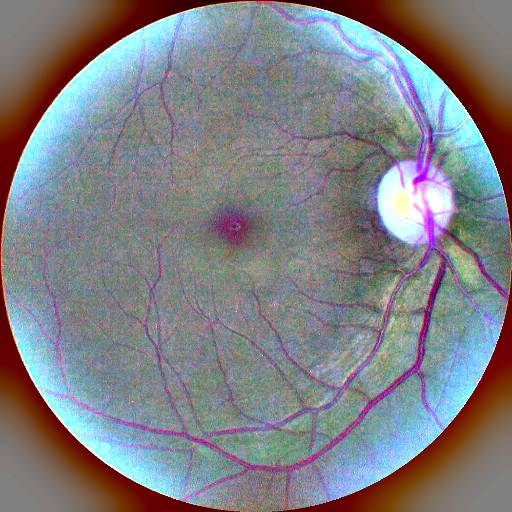

In [18]:
img_path = '/run/media/linwenxing/ExData/kaggle_datasets/aptos2019-blindness-detection-GaussianBlur/Label0_No_DR/0a4e1a29ffff_blurred.png'
# 用 pillow 载入
from PIL import Image
img_pil = Image.open(img_path)
img_pil

In [19]:
np.array(img_pil).shape

(512, 512, 3)

## 1.5 基础的路径设置

In [20]:
# 数据集文件夹路径
train_path = r'/run/media/linwenxing/ExData/kaggle_datasets/aptos2019-blindness-detection-GaussianBlur/'
test_path = r'/run/media/linwenxing/ExData/kaggle_datasets/aptos2019-blindness-detection/'
print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 /run/media/linwenxing/ExData/kaggle_datasets/aptos2019-blindness-detection-GaussianBlur/
测试集路径 /run/media/linwenxing/ExData/kaggle_datasets/aptos2019-blindness-detection/


## 1.6 载入图像分类数据集

In [21]:
from torchvision import datasets

# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)
# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)
print('-------------------------------------')
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)
print('-------------------------------------')

训练集图像数量 3662
类别个数 5
各类别名称 ['Label0_No_DR', 'Label1_Mild', 'Label2_Moderate', 'Label3_Severe', 'Label4_Proliferative_DR']
-------------------------------------
测试集图像数量 5589
类别个数 2
各类别名称 ['test_images', 'train_images']
-------------------------------------


## 1.7 csv文件中编码和label的对应

In [22]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)
print(class_names,'\n')

# 映射关系：类别 到 索引号
train_dataset.class_to_idx
print(train_dataset.class_to_idx,'\n')
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}
print(idx_to_labels)

# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)

['Label0_No_DR', 'Label1_Mild', 'Label2_Moderate', 'Label3_Severe', 'Label4_Proliferative_DR'] 

{'Label0_No_DR': 0, 'Label1_Mild': 1, 'Label2_Moderate': 2, 'Label3_Severe': 3, 'Label4_Proliferative_DR': 4} 

{0: 'Label0_No_DR', 1: 'Label1_Mild', 2: 'Label2_Moderate', 3: 'Label3_Severe', 4: 'Label4_Proliferative_DR'}


## 1.8 定义 dataloader
DataLoader 是 python生成器，每次调用返回一个 batch 的数据

In [26]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )
# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

# 查看一个batch的图像和标注
images, labels = next(iter(train_loader))
print('数据格式是：',images.shape,'\n')
# 有32张 三通道的 256*256的图片
print('数据的label情况：\n',labels)

数据格式是： torch.Size([32, 3, 256, 256]) 

数据的label情况：
 tensor([2, 0, 0, 0, 0, 3, 0, 2, 2, 2, 0, 4, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 0,
        2, 0, 1, 0, 0, 0, 2, 2])


## 1.9 可视化一个 batch（目前不可用）

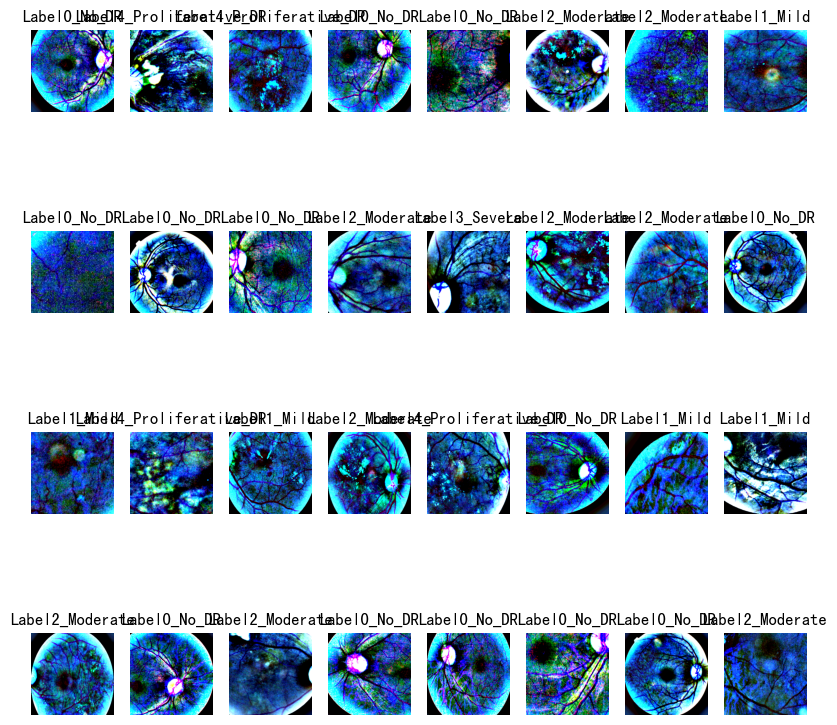

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# 将PyTorch张量转换为NumPy数组
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

# 取出一个batch的图像和标注
images, labels = next(iter(train_loader))

# 加载类别到索引号的映射关系
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

# 将图像和标注可视化
plt.figure(figsize=(10, 10))
for i in range(len(images)):
    plt.subplot(4, 8, i + 1)
    image = to_numpy(images[i]).transpose((1, 2, 0))  # 转换通道顺序
    image = np.clip(image, 0, 1)  # 将图像数据裁剪到合法范围 [0, 1]
    plt.imshow(image)
    class_index = labels[i].item()
    plt.title(idx_to_labels[class_index])
    plt.axis('off')
plt.show()


# 二、开始训练

## 2.1 第一种方式-只微调训练模型最后一层（全连接层）

In [40]:
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)
model.fc

# 只微调训练最后一层全连接层的参数，其它层冻结
optimizer = optim.Adam(model.fc.parameters())

## 2.2 第一种方式-只微调训练模型最后一层（全连接层）

## 2.3 第一种方式-只微调训练模型最后一层（全连接层）

## 2.4 训练配置

In [43]:
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss() 

# 训练轮次 Epoch
EPOCHS = 30

# 学习率降低策略
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [45]:
def train_one_batch(images, labels):
    '''
    运行一个 batch 的训练，返回当前 batch 的训练日志
    '''
    
    # 获得一个 batch 的数据和标注
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images) # 输入模型，执行前向预测
    loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值
    
    # 优化更新权重
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 获取当前 batch 的标签类别和预测类别
    _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
    preds = preds.cpu().numpy()
    loss = loss.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    log_train = {}
    log_train['epoch'] = epoch
    log_train['batch'] = batch_idx
    # 计算分类评估指标
    log_train['train_loss'] = loss
    log_train['train_accuracy'] = accuracy_score(labels, preds)
    # log_train['train_precision'] = precision_score(labels, preds, average='macro')
    # log_train['train_recall'] = recall_score(labels, preds, average='macro')
    # log_train['train_f1-score'] = f1_score(labels, preds, average='macro')
    
    return log_train

def evaluate_testset():
    '''
    在整个测试集上评估，返回分类评估指标日志
    '''

    loss_list = []
    labels_list = []
    preds_list = []
    
    with torch.no_grad():
        for images, labels in test_loader: # 生成一个 batch 的数据和标注
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # 输入模型，执行前向预测

            # 获取整个测试集的标签类别和预测类别
            _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
            preds = preds.cpu().numpy()
            loss = criterion(outputs, labels) # 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
            loss = loss.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            loss_list.append(loss)
            labels_list.extend(labels)
            preds_list.extend(preds)
        
    log_test = {}
    log_test['epoch'] = epoch
    
    # 计算分类评估指标
    log_test['test_loss'] = np.mean(loss_list)
    log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
    log_test['test_precision'] = precision_score(labels_list, preds_list, average='macro')
    log_test['test_recall'] = recall_score(labels_list, preds_list, average='macro')
    log_test['test_f1-score'] = f1_score(labels_list, preds_list, average='macro')
    
    return log_test

## 2.5 训练开始之前，记录日志

In [46]:
epoch = 0
batch_idx = 0
best_test_accuracy = 0

# 训练日志-训练集
# df_train_log = pd.DataFrame()
# log_train = {}
# log_train['epoch'] = 0
# log_train['batch'] = 0
# images, labels = next(iter(train_loader))
# log_train.update(train_one_batch(images, labels))
# df_train_log = df_train_log.append(log_train, ignore_index=True)
import pandas as pd

# 初始化 df_train_log 为一个空的 DataFrame
df_train_log = pd.DataFrame()

# 创建 log_train 字典
log_train = {
    'epoch': 0,
    'batch': 0,
}

# 从 train_loader 中获取 images 和 labels
images, labels = next(iter(train_loader))

# 更新 log_train 字典
log_train.update(train_one_batch(images, labels))

# 将 log_train 转换为 DataFrame，并使用 concat 连接到 df_train_log
df_train_log = pd.concat([df_train_log, pd.DataFrame([log_train])], ignore_index=True)
print(df_train_log,'\n')



,epoch,batch,train_loss,train_accuracy
0,0,0,1.6339135,0.21875


## 2.6 wandb记录

In [ ]:
import wandb
wandb.init(project='DR_train', name=time.strftime('%m%d%H%M%S'))

# 三、开始进行训练

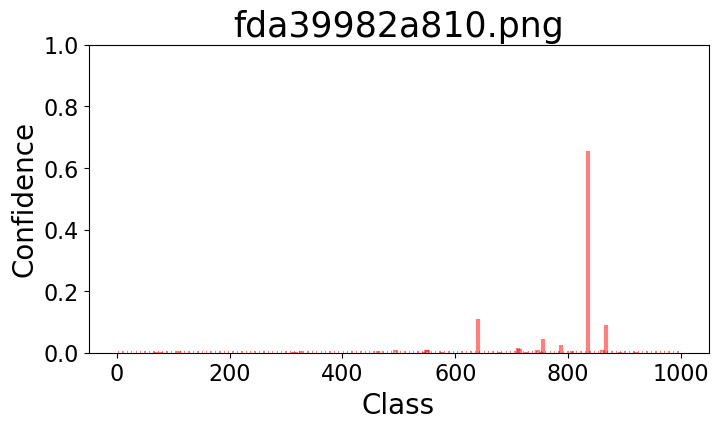

In [29]:
for epoch in range(1, EPOCHS+1):
    
    print(f'Epoch {epoch}/{EPOCHS}')
    
    ## 训练阶段
    model.train()
    for images, labels in tqdm(train_loader): # 获得一个 batch 的数据和标注
        batch_idx += 1
        log_train = train_one_batch(images, labels)
        df_train_log = df_train_log.append(log_train, ignore_index=True)
        wandb.log(log_train)
        
    lr_scheduler.step()

    ## 测试阶段
    model.eval()
    log_test = evaluate_testset()
    df_test_log = df_test_log.append(log_test, ignore_index=True)
    wandb.log(log_test)
    
    # 保存最新的最佳模型文件
    if log_test['test_accuracy'] > best_test_accuracy: 
        # 删除旧的最佳模型文件(如有)
        old_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy)
        if os.path.exists(old_best_checkpoint_path):
            os.remove(old_best_checkpoint_path)
        # 保存新的最佳模型文件
        best_test_accuracy = log_test['test_accuracy']
        new_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(log_test['test_accuracy'])
        torch.save(model, new_best_checkpoint_path)
        print('保存新的最佳模型', 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy))
        # best_test_accuracy = log_test['test_accuracy']

df_train_log.to_csv('训练日志-训练集.csv', index=False)
df_test_log.to_csv('训练日志-测试集.csv', index=False)

### 取置信度最大的 n 个结果

In [30]:
n = 10
top_n = torch.topk(pred_softmax, n)

In [31]:
top_n

torch.return_types.topk(
values=tensor([[0.6559, 0.1111, 0.0893, 0.0444, 0.0248, 0.0164, 0.0058, 0.0057, 0.0049,
         0.0046]], grad_fn=<TopkBackward0>),
indices=tensor([[835, 640, 868, 755, 787, 712, 807, 463, 111, 326]]))

In [32]:
# 解析出类别
pred_ids = top_n[1].cpu().detach().numpy().squeeze()

In [33]:
pred_ids

array([835, 640, 868, 755, 787, 712, 807, 463, 111, 326])

In [34]:
# 解析出置信度
confs = top_n[0].cpu().detach().numpy().squeeze()

In [35]:
confs

array([0.6559437 , 0.11106917, 0.08932722, 0.04435762, 0.0248119 ,
       0.01640251, 0.00583203, 0.00567851, 0.00487554, 0.00462116],
      dtype=float32)

### 载入ImageNet 1000图像分类标签

ImageNet 1000类别中文释义：https://github.com/ningbonb/imagenet_classes_chinese

In [36]:
df = pd.read_csv('imagenet_class_index.csv')

In [37]:
df

,ID,class,wordnet,Chinese
0,0,tench,n01440764,丁鲷
1,1,goldfish,n01443537,金鱼
2,2,great_white_shark,n01484850,大白鲨
3,3,tiger_shark,n01491361,虎鲨
4,4,hammerhead,n01494475,锤头鲨
...,...,...,...,...
995,995,earthstar,n13044778,地星（菌类）
996,996,hen-of-the-woods,n13052670,多叶奇果菌
997,997,bolete,n13054560,牛肝菌
998,998,ear,n13133613,玉米穗


In [38]:
idx_to_labels = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = [row['wordnet'], row['class']]

In [39]:
# idx_to_labels

### 图像分类结果写在原图上

In [40]:
# 用 opencv 载入原图
img_bgr = cv2.imread(img_path)

In [41]:
for i in range(n):
    class_name = idx_to_labels[pred_ids[i]][1] # 获取类别名称
    confidence = confs[i] * 100 # 获取置信度
    text = '{:<15} {:>.4f}'.format(class_name, confidence)
    print(text)
    
    # !图片，添加的文字，左上角坐标，字体，字号，bgr颜色，线宽
    img_bgr = cv2.putText(img_bgr, text, (25, 50 + 40 * i), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (0, 0, 255), 3)

sundial         65.5944
manhole_cover   11.1069
tray            8.9327
radio_telescope 4.4358
shield          2.4812
Petri_dish      1.6403
solar_dish      0.5832
bucket          0.5679
nematode        0.4876
lycaenid        0.4621


In [42]:
# 保存图像
cv2.imwrite('output/img_pred.jpg', img_bgr)

True

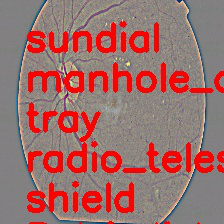

In [43]:
# 载入预测结果图像
img_pred = Image.open('output/img_pred.jpg')
img_pred

### 图像和柱状图一起显示

/tmp/ipykernel_40997/3884211912.py:20: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_40997/3884211912.py:20: UserWarning: Glyph 26723 (\N{CJK UNIFIED IDEOGRAPH-6863}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_40997/3884211912.py:20: UserWarning: Glyph 27605 (\N{CJK UNIFIED IDEOGRAPH-6BD5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_40997/3884211912.py:20: UserWarning: Glyph 35774 (\N{CJK UNIFIED IDEOGRAPH-8BBE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_40997/3884211912.py:21: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  fig.savefig('output/预测图+柱状图.jpg')
/tmp/ipykernel_40997/3884211912.py:21: UserWarning: Glyph 26723 (\N{CJK UNIFIED IDEOGRAPH-6863}) missing from current font.
  fig.savefig('output/预测图+柱状图.jpg')
/tmp/ipykernel_40997/3884211912.py:21: UserWarning: Glyph 27605 (\N{CJK UNIFIED IDEOGRAPH-6BD5}) mis

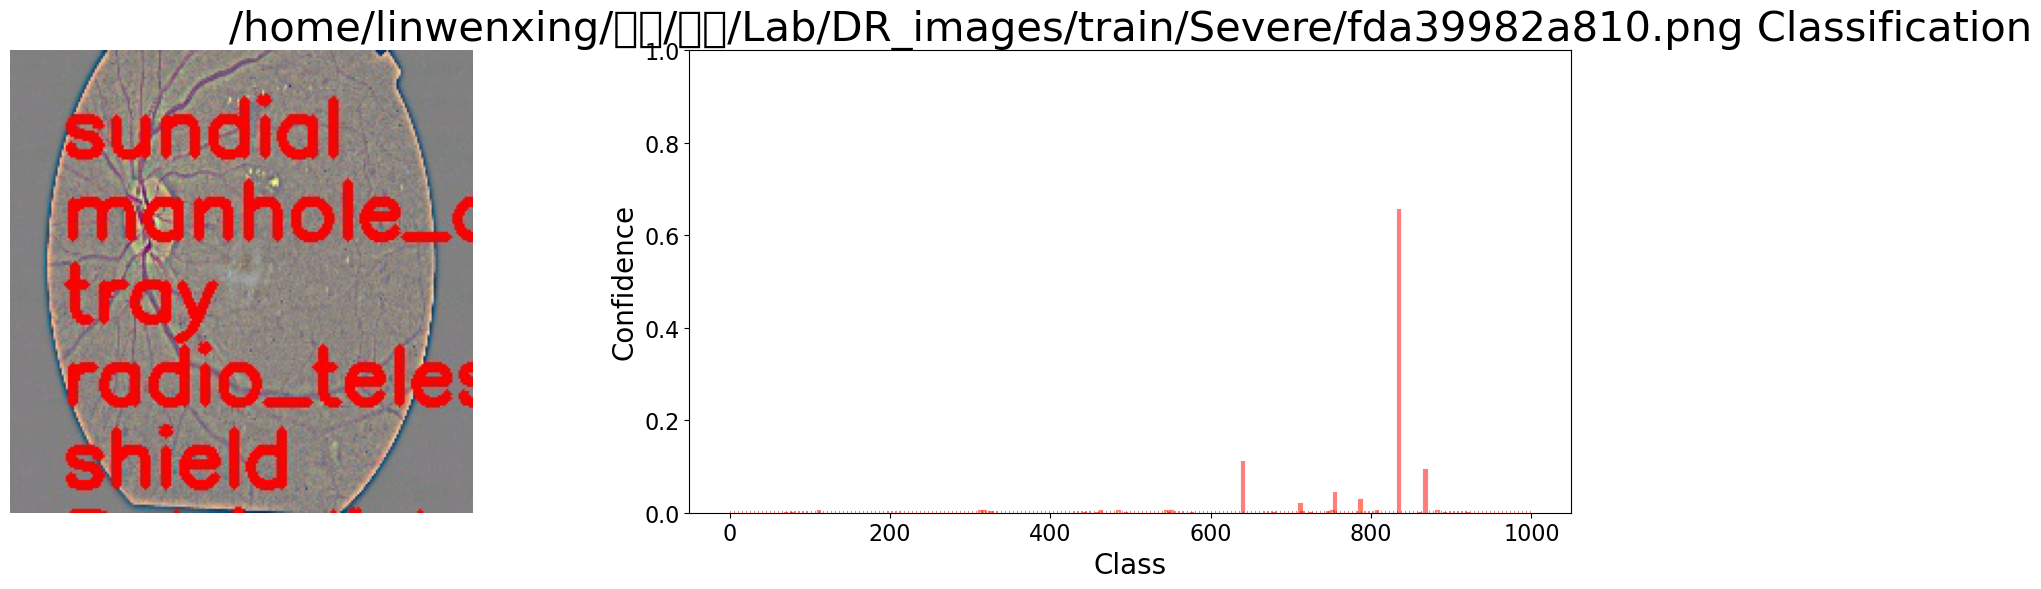

In [44]:
fig = plt.figure(figsize=(18,6))

# 绘制左图-预测图
ax1 = plt.subplot(1,2,1)
ax1.imshow(img_pred)
ax1.axis('off')

# 绘制右图-柱状图
ax2 = plt.subplot(1,2,2)
x = df['ID']
y = pred_softmax.cpu().detach().numpy()[0]
ax2.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)

plt.ylim([0, 1.0]) # y轴取值范围
plt.title('{} Classification'.format(img_path), fontsize=30)
plt.xlabel('Class', fontsize=20)
plt.ylabel('Confidence', fontsize=20)
ax2.tick_params(labelsize=16) # 坐标文字大小

plt.tight_layout()
fig.savefig('output/预测图+柱状图.jpg')

### 预测结果表格输出

In [38]:
pred_df = pd.DataFrame() # 预测结果表格
for i in range(n):
    class_name = idx_to_labels[pred_ids[i]][1] # 获取类别名称
    label_idx = int(pred_ids[i]) # 获取类别号
    wordnet = idx_to_labels[pred_ids[i]][0] # 获取 WordNet
    confidence = confs[i] * 100 # 获取置信度
    pred_df = pred_df.append({'Class':class_name, 'Class_ID':label_idx, 'Confidence(%)':confidence, 'WordNet':wordnet}, ignore_index=True) # 预测结果表格添加一行
display(pred_df) # 展示预测结果表格

,Class,Class_ID,Confidence(%),WordNet
0,basketball,430.0,59.879553,n02802426
1,cowboy_boot,514.0,35.560247,n03124043
2,croquet_ball,522.0,0.642725,n03134739
3,Loafer,630.0,0.471235,n03680355
4,clog,502.0,0.411556,n03047690
5,running_shoe,770.0,0.406664,n04120489
6,barrel,427.0,0.369108,n02795169
7,rugby_ball,768.0,0.247855,n04118538
8,soccer_ball,805.0,0.218840,n04254680
9,mud_turtle,35.0,0.216441,n01667114
